In [9]:
import json
import math
import cv2
import PIL
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121, VGG16
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import f1_score
%matplotlib inline

In [10]:

import os
# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io
# General packages
from IPython.display import display
# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go

BATCH_SIZE = 15
TRAIN_VAL_RATIO = 0.27
EPOCHS = 11
LR = 0.00010409613402110064

train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
test_df = pd.read_csv('../input/prostate-cancer-grade-assessment/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(10616, 4)
(3, 2)


,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [11]:
def preprocess_image(image_path, desired_size=224):
    biopsy = openslide.OpenSlide(image_path)
    im = np.array(biopsy.get_thumbnail(size=(desired_size,desired_size)))
    im = Image.fromarray(im)
    im = im.resize((desired_size,desired_size)) 
    im = np.array(im)
    return im

In [12]:
# get the number of training images from the target\id dataset
N = train_df.shape[0]
# create an empty matrix for storing the images
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)
# loop through the images from the images ids from the target\id dataset
# then grab the cooresponding image from disk, pre-process, and store in matrix in memory
for i, image_id in enumerate(tqdm(train_df['image_id'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/prostate-cancer-grade-assessment/train_images/{image_id}.tiff'
    )

y_train = pd.get_dummies(train_df['isup_grade']).values

print(x_train.shape)
print(y_train.shape)

100%|██████████| 10616/10616 [28:20<00:00,  6.24it/s]

(10616, 224, 224, 3)
(10616, 6)


In [13]:
# Further target pre-processing

# Instead of predicting a single label, we will change our target to be a multilabel problem; 
# i.e., if the target is a certain class, then it encompasses all the classes before it. 
# E.g. encoding a class 4 retinopathy would usually be [0, 0, 0, 1], 
# but in our case we will predict [1, 1, 1, 1]. For more details, 
# please check out Lex's kernel.

y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 5] = y_train[:, 5]

for i in range(4, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [2892 2666 1343 1242 1249 1224]
Multilabel version: [10616  7724  5058  3715  2473  1224]


In [14]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=TRAIN_VAL_RATIO, 
    random_state=2020
)

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [15]:
from tensorflow.keras import backend as K


def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

## DenseNet121

In [9]:
# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [10]:
def build_model(LR=LR):
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.80))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(6, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=LR),
        metrics=['accuracy', f1_m,precision_m, recall_m]
    )
    
    return model

In [11]:
model = build_model()
model.summary()

x_train.shape[0]// BATCH_SIZE

history = model.fit(
    data_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/11


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733596400.089522     580 service.cc:145] XLA service 0x7b20e8002660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733596400.089583     580 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733596400.089588     580 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733596491.953214     580 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1733596492

516/516 ━━━━━━━━━━━━━━━━━━━━ 344s 378ms/step - accuracy: 0.1894 - f1_m: 0.5244 - loss: 0.8164 - precision_m: 0.5205 - recall_m: 0.5349 - val_accuracy: 0.3031 - val_f1_m: 0.4613 - val_loss: 0.6583 - val_precision_m: 0.6370 - val_recall_m: 0.3677
Epoch 2/11
  1/516 ━━━━━━━━━━━━━━━━━━━━ 1:41 197ms/step - accuracy: 0.4667 - f1_m: 0.6383 - loss: 0.7187 - precision_m: 0.6977 - recall_m: 0.5882

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


516/516 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4667 - f1_m: 0.6383 - loss: 0.7187 - precision_m: 0.6977 - recall_m: 0.5882 - val_accuracy: 0.3073 - val_f1_m: 0.4622 - val_loss: 0.6594 - val_precision_m: 0.6360 - val_recall_m: 0.3694
Epoch 3/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 89s 171ms/step - accuracy: 0.3486 - f1_m: 0.6351 - loss: 0.6494 - precision_m: 0.6394 - recall_m: 0.6384 - val_accuracy: 0.6931 - val_f1_m: 0.6944 - val_loss: 0.5746 - val_precision_m: 0.8821 - val_recall_m: 0.5776
Epoch 4/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3333 - f1_m: 0.7158 - loss: 0.5711 - precision_m: 0.8095 - recall_m: 0.6415 - val_accuracy: 0.6969 - val_f1_m: 0.6927 - val_loss: 0.5764 - val_precision_m: 0.8829 - val_recall_m: 0.5749
Epoch 5/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 89s 170ms/step - accuracy: 0.5303 - f1_m: 0.7249 - loss: 0.5575 - precision_m: 0.7331 - recall_m: 0.7257 - val_accuracy: 0.5501 - val_f1_m: 0.8094 - val_loss: 0.4803 - val_precision_m: 0.8156 - val_recall_m: 0.

<Axes: >

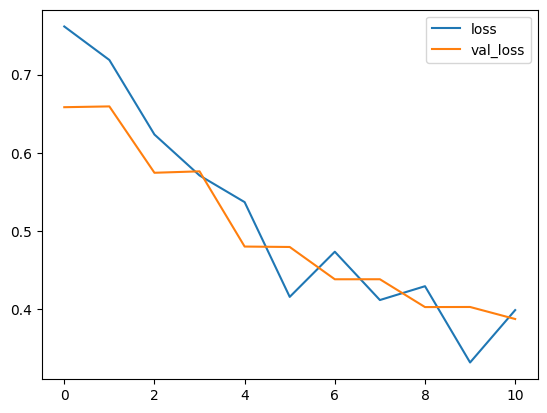

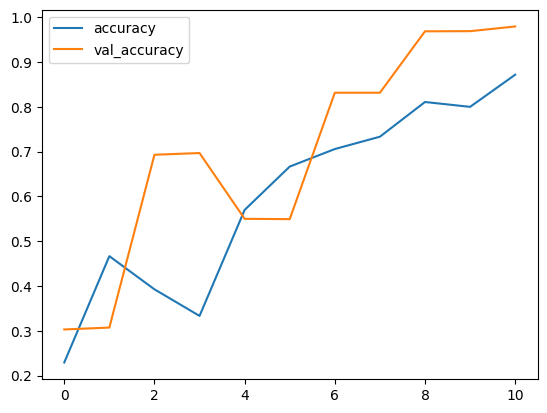

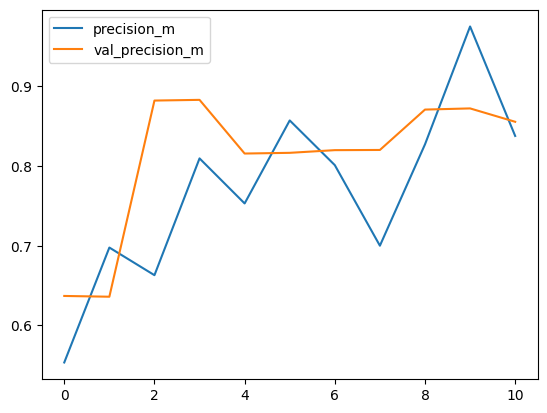

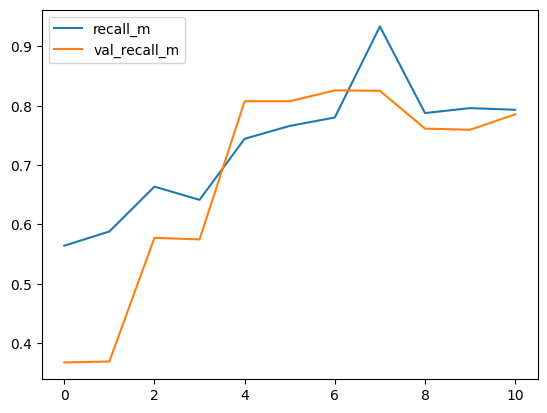

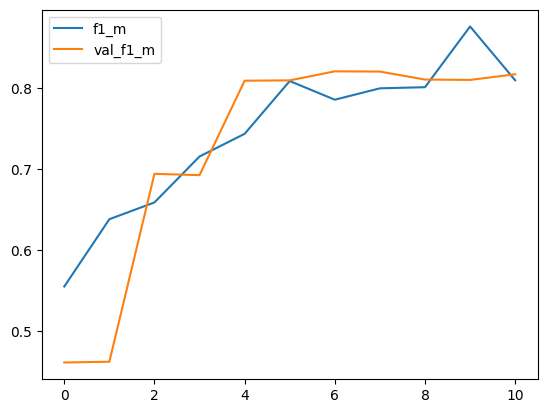

In [12]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()
history_df[['precision_m', 'val_precision_m']].plot()
history_df[['recall_m', 'val_recall_m']].plot()
history_df[['f1_m', 'val_f1_m']].plot()

## VGG16

In [17]:
# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

densenet = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

In [18]:
def build_model(LR=LR):
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.80))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(6, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=LR),
        metrics=['accuracy', f1_m,precision_m, recall_m]
    )
    
    return model

In [19]:
modelVGG = build_model()
modelVGG.summary()

x_train.shape[0]// BATCH_SIZE

historyVGG = modelVGG.fit(
    data_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val)
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 134s 241ms/step - accuracy: 0.1602 - f1_m: 0.4873 - loss: 0.8170 - precision_m: 0.4853 - recall_m: 0.4958 - val_accuracy: 0.0000e+00 - val_f1_m: 0.4132 - val_loss: 0.7595 - val_precision_m: 0.3589 - val_recall_m: 0.4898
Epoch 2/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.1333 - f1_m: 0.5000 - loss: 0.7601 - precision_m: 0.4681 - recall_m: 0.5366 - val_accuracy: 0.0000e+00 - val_f1_m: 0.4132 - val_loss: 0.7597 - val_precision_m: 0.3589 - val_recall_m: 0.4898
Epoch 3/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 119s 229ms/step - accuracy: 0.2918 - f1_m: 0.5423 - loss: 0.7031 - precision_m: 0.5407 - recall_m: 0.5510 - val_accuracy: 0.0000e+00 - val_f1_m: 0.6210 - val_loss: 0.6811 - val_precision_m: 0.4963 - val_recall_m: 0.8346
Epoch 4/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.4667 - f1_m: 0.6364 - loss: 0.6251 - precision_m: 0.6364 - recall_m: 0.6364 - val_accuracy: 0.0000e+00 - val_f1_m: 0.6224 - val_loss: 0.6808 - val_precisi

<Axes: >

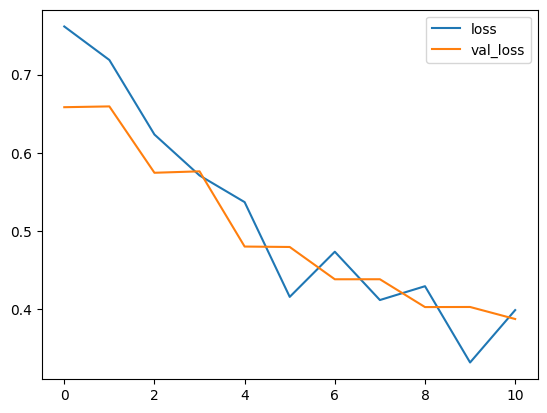

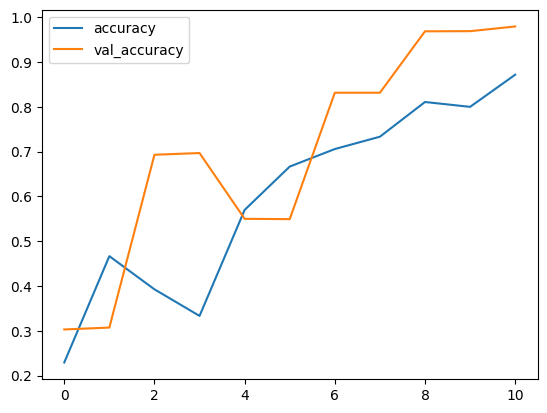

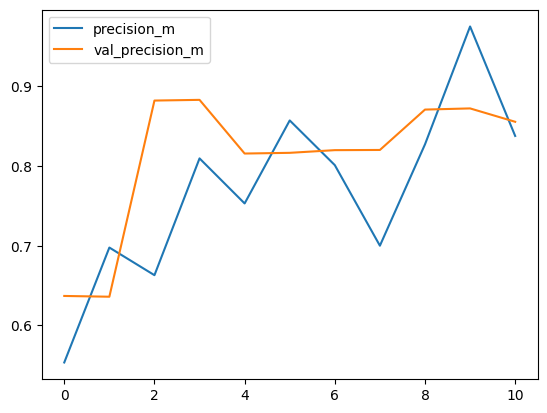

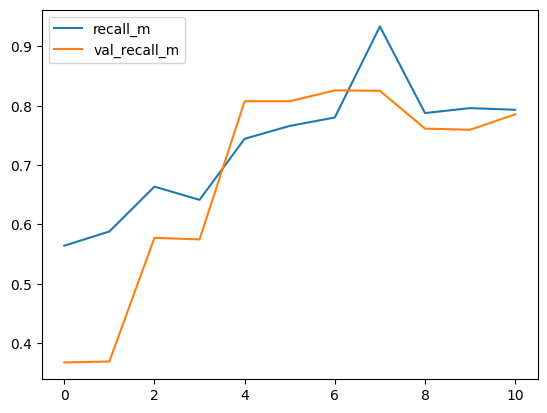

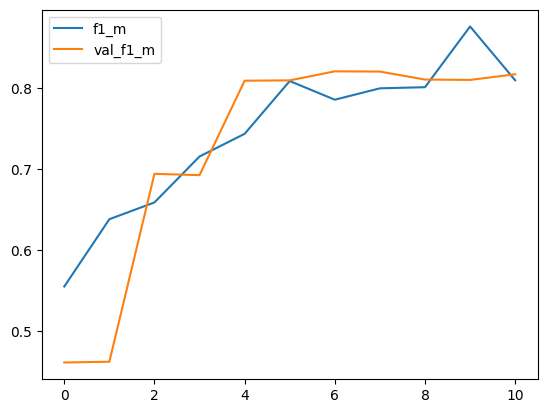

In [20]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()
history_df[['precision_m', 'val_precision_m']].plot()
history_df[['recall_m', 'val_recall_m']].plot()
history_df[['f1_m', 'val_f1_m']].plot()

## ENet 7

In [16]:
from keras.applications import EfficientNetB7

In [17]:
# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

enet = EfficientNetB7(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

In [18]:
def build_model(LR=LR):
    model = Sequential()
    model.add(enet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.80))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(6, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=LR),
        metrics=['accuracy', f1_m,precision_m, recall_m]
    )
    
    return model

In [19]:
enet_model = build_model()
enet_model.summary()

x_train.shape[0]// BATCH_SIZE

enet_history = enet_model.fit(
    data_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

Epoch 1/11


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733600462.398317    1054 service.cc:145] XLA service 0x785a68003de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733600462.398380    1054 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733600462.398386    1054 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733600732.338763    1054 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


516/516 ━━━━━━━━━━━━━━━━━━━━ 933s 1s/step - accuracy: 0.2070 - f1_m: 0.5420 - loss: 0.7951 - precision_m: 0.5395 - recall_m: 0.5514 - val_accuracy: 0.6645 - val_f1_m: 0.7662 - val_loss: 0.5437 - val_precision_m: 0.7769 - val_recall_m: 0.7598
Epoch 2/11
  1/516 ━━━━━━━━━━━━━━━━━━━━ 3:59 465ms/step - accuracy: 0.2667 - f1_m: 0.6292 - loss: 0.6854 - precision_m: 0.6667 - recall_m: 0.5957

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


516/516 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.2667 - f1_m: 0.6292 - loss: 0.6854 - precision_m: 0.6667 - recall_m: 0.5957 - val_accuracy: 0.6645 - val_f1_m: 0.7666 - val_loss: 0.5434 - val_precision_m: 0.7758 - val_recall_m: 0.7617
Epoch 3/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 257s 495ms/step - accuracy: 0.4063 - f1_m: 0.6589 - loss: 0.6210 - precision_m: 0.6680 - recall_m: 0.6604 - val_accuracy: 0.7367 - val_f1_m: 0.7966 - val_loss: 0.4981 - val_precision_m: 0.8326 - val_recall_m: 0.7678
Epoch 4/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6667 - f1_m: 0.6486 - loss: 0.6357 - precision_m: 0.6000 - recall_m: 0.7059 - val_accuracy: 0.7370 - val_f1_m: 0.7963 - val_loss: 0.4979 - val_precision_m: 0.8327 - val_recall_m: 0.7671
Epoch 5/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 257s 496ms/step - accuracy: 0.6360 - f1_m: 0.7662 - loss: 0.5199 - precision_m: 0.7894 - recall_m: 0.7541 - val_accuracy: 0.8483 - val_f1_m: 0.8142 - val_loss: 0.4369 - val_precision_m: 0.8483 - val_recall_m

<Axes: >

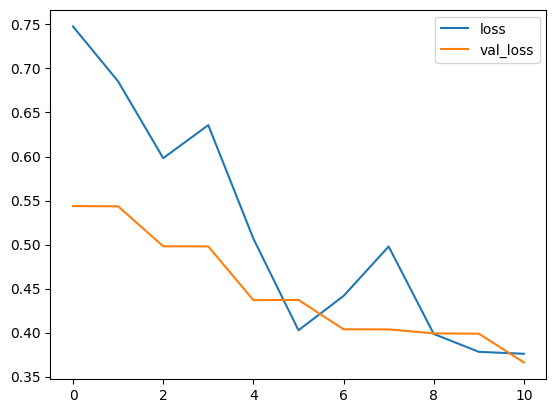

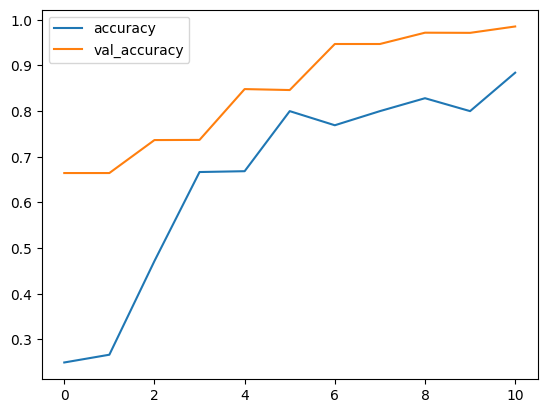

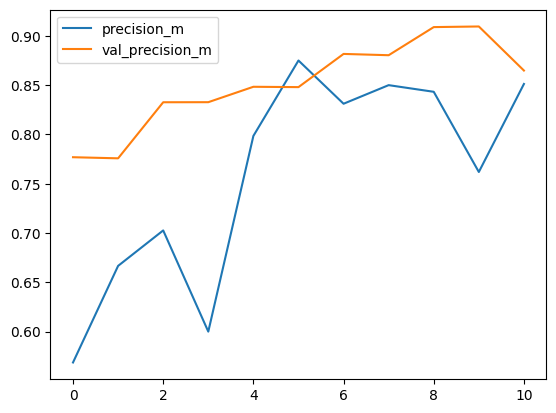

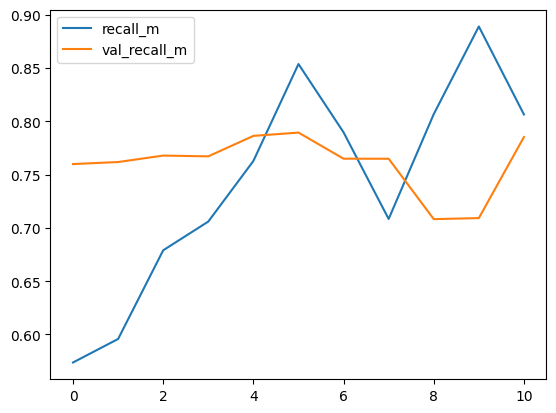

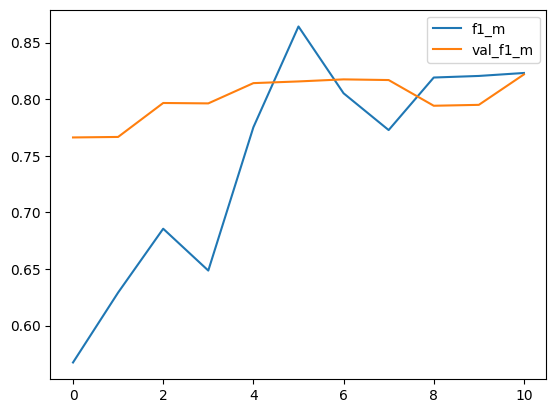

In [20]:
enet_history_df = pd.DataFrame(enet_history.history)
enet_history_df[['loss', 'val_loss']].plot()
enet_history_df[['accuracy', 'val_accuracy']].plot()
enet_history_df[['precision_m', 'val_precision_m']].plot()
enet_history_df[['recall_m', 'val_recall_m']].plot()
enet_history_df[['f1_m', 'val_f1_m']].plot()

## NASNet 7

In [21]:
from keras.applications import NASNetMobile

In [22]:
# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

NASnet = NASNetMobile(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
def build_model(LR=LR):
    model = Sequential()
    model.add(NASnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.80))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(6, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=LR),
        metrics=['accuracy', f1_m,precision_m, recall_m]
    )
    
    return model

In [24]:
NASnet_model = build_model()
NASnet_model.summary()

x_train.shape[0]// BATCH_SIZE

NASnet_history = NASnet_model.fit(
    data_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val)
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ NASNet (Functional)             │ ?                      │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 4,232,978 (16.15 MB)

 Non-trainable params: 36,738 (143.51 KB)

Epoch 1/11


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


516/516 ━━━━━━━━━━━━━━━━━━━━ 441s 419ms/step - accuracy: 0.1839 - f1_m: 0.5199 - loss: 0.8176 - precision_m: 0.5098 - recall_m: 0.5378 - val_accuracy: 3.4880e-04 - val_f1_m: 0.5569 - val_loss: 0.7934 - val_precision_m: 0.4454 - val_recall_m: 0.7481
Epoch 2/11
  1/516 ━━━━━━━━━━━━━━━━━━━━ 1:38 192ms/step - accuracy: 0.2667 - f1_m: 0.5275 - loss: 0.7829 - precision_m: 0.5455 - recall_m: 0.5106

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2667 - f1_m: 0.5275 - loss: 0.7829 - precision_m: 0.5455 - recall_m: 0.5106 - val_accuracy: 6.9759e-04 - val_f1_m: 0.5551 - val_loss: 0.7935 - val_precision_m: 0.4435 - val_recall_m: 0.7471
Epoch 3/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.3501 - f1_m: 0.6387 - loss: 0.6469 - precision_m: 0.6239 - recall_m: 0.6647 - val_accuracy: 0.0000e+00 - val_f1_m: 0.4965 - val_loss: 0.7147 - val_precision_m: 0.4608 - val_recall_m: 0.5419
Epoch 4/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4667 - f1_m: 0.6750 - loss: 0.5785 - precision_m: 0.6279 - recall_m: 0.7297 - val_accuracy: 0.0000e+00 - val_f1_m: 0.4966 - val_loss: 0.7147 - val_precision_m: 0.4609 - val_recall_m: 0.5419
Epoch 5/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.5348 - f1_m: 0.7294 - loss: 0.5417 - precision_m: 0.7173 - recall_m: 0.7534 - val_accuracy: 0.0764 - val_f1_m: 0.7614 - val_loss: 0.6146 - val_precision_m: 0.6939 - val_re

<Axes: >

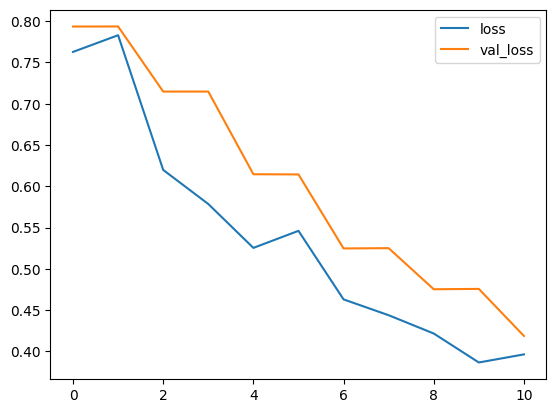

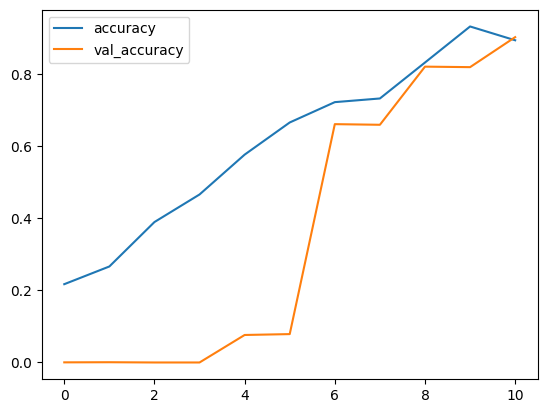

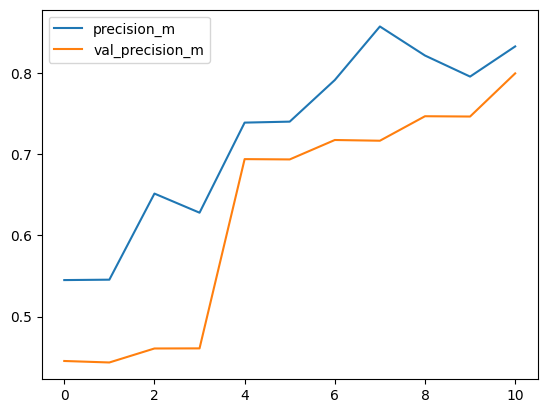

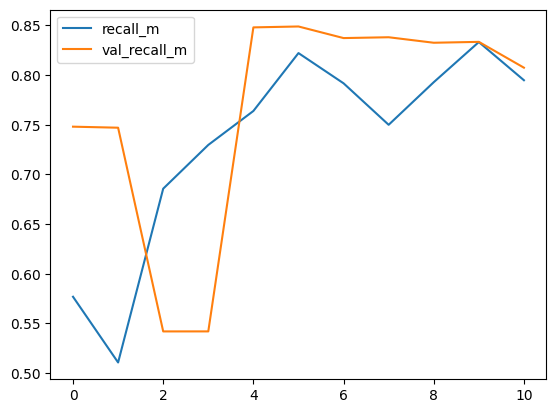

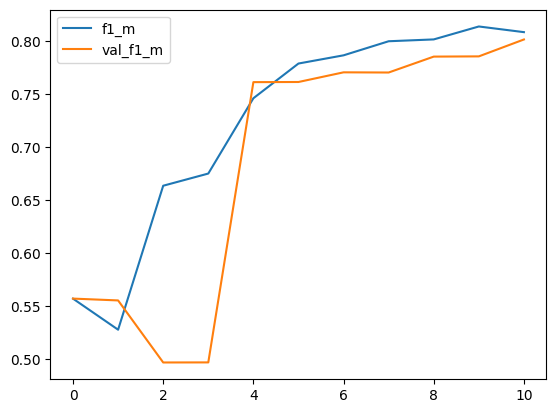

In [25]:
NASnet_history_df = pd.DataFrame(NASnet_history.history)
NASnet_history_df[['loss', 'val_loss']].plot()
NASnet_history_df[['accuracy', 'val_accuracy']].plot()
NASnet_history_df[['precision_m', 'val_precision_m']].plot()
NASnet_history_df[['recall_m', 'val_recall_m']].plot()
NASnet_history_df[['f1_m', 'val_f1_m']].plot()

## MobileNet

In [26]:
from keras.applications import MobileNet

In [27]:
# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

MobileNet_keras = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
def build_model(LR=LR):
    model = Sequential()
    model.add(MobileNet_keras)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.80))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(6, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=LR),
        metrics=['accuracy', f1_m,precision_m, recall_m]
    )
    
    return model

In [29]:
MobileNet_model = build_model()
MobileNet_model.summary()

x_train.shape[0]// BATCH_SIZE

MobileNet_history = MobileNet_model.fit(
    data_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val)
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/11


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


516/516 ━━━━━━━━━━━━━━━━━━━━ 126s 184ms/step - accuracy: 0.1994 - f1_m: 0.5291 - loss: 0.8010 - precision_m: 0.5286 - recall_m: 0.5369 - val_accuracy: 0.3973 - val_f1_m: 0.5943 - val_loss: 0.5663 - val_precision_m: 0.8049 - val_recall_m: 0.4743
Epoch 2/11
  1/516 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.2000 - f1_m: 0.5778 - loss: 0.6924 - precision_m: 0.5306 - recall_m: 0.6341

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2000 - f1_m: 0.5778 - loss: 0.6924 - precision_m: 0.5306 - recall_m: 0.6341 - val_accuracy: 0.4029 - val_f1_m: 0.5894 - val_loss: 0.5675 - val_precision_m: 0.8063 - val_recall_m: 0.4678
Epoch 3/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 74s 142ms/step - accuracy: 0.3197 - f1_m: 0.6323 - loss: 0.6500 - precision_m: 0.6391 - recall_m: 0.6345 - val_accuracy: 0.6805 - val_f1_m: 0.7087 - val_loss: 0.5580 - val_precision_m: 0.9283 - val_recall_m: 0.5765
Epoch 4/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5333 - f1_m: 0.7551 - loss: 0.5603 - precision_m: 0.8222 - recall_m: 0.6981 - val_accuracy: 0.6791 - val_f1_m: 0.7095 - val_loss: 0.5576 - val_precision_m: 0.9270 - val_recall_m: 0.5781
Epoch 5/11
516/516 ━━━━━━━━━━━━━━━━━━━━ 75s 143ms/step - accuracy: 0.4834 - f1_m: 0.7264 - loss: 0.5546 - precision_m: 0.7355 - recall_m: 0.7269 - val_accuracy: 0.6920 - val_f1_m: 0.7654 - val_loss: 0.4733 - val_precision_m: 0.9168 - val_recall_m: 0.66

<Axes: >

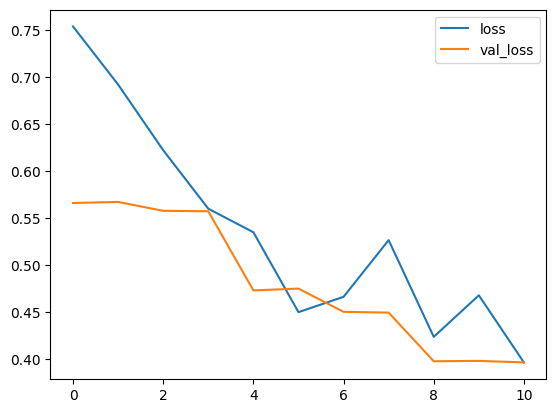

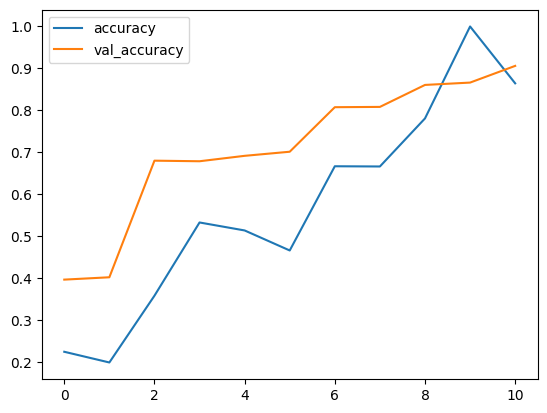

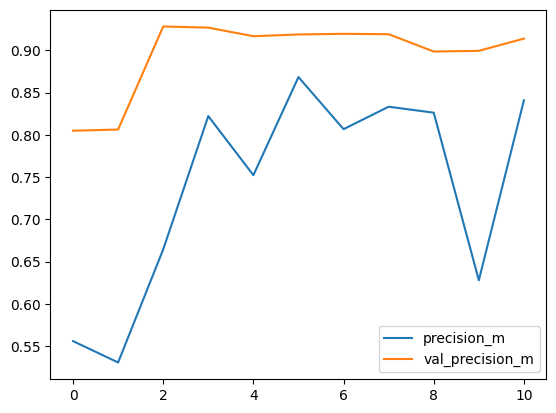

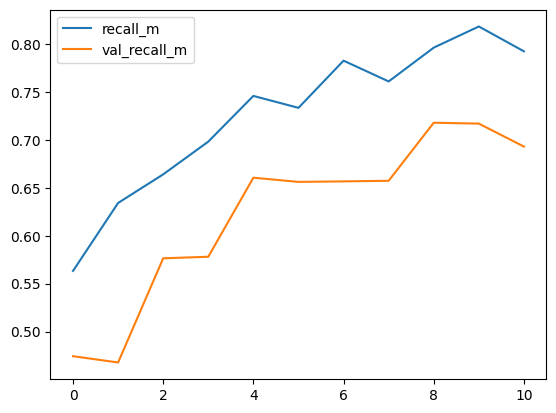

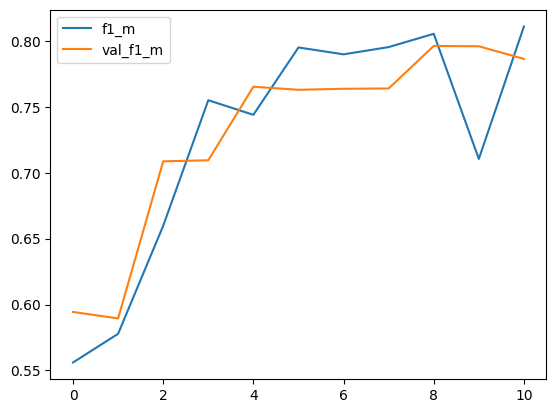

In [30]:
MobileNet_history_df = pd.DataFrame(MobileNet_history.history)
MobileNet_history_df[['loss', 'val_loss']].plot()
MobileNet_history_df[['accuracy', 'val_accuracy']].plot()
MobileNet_history_df[['precision_m', 'val_precision_m']].plot()
MobileNet_history_df[['recall_m', 'val_recall_m']].plot()
MobileNet_history_df[['f1_m', 'val_f1_m']].plot()